Logistic Regression for Customer Churn Using Pyspark

Use case : predicting which clients are most likely to cancel a subscription i.e ‘leave a company’ based on their usage of the service.

In [1]:
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("ChurnCustomer").getOrCreate()

In [3]:
df = spark.read.csv("churnCustomer.csv",inferSchema=True,header=True)

In [4]:
df.printSchema()

root
 |-- customerID: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- SeniorCitizen: integer (nullable = true)
 |-- Partner: string (nullable = true)
 |-- Dependents: string (nullable = true)
 |-- tenure: integer (nullable = true)
 |-- PhoneService: string (nullable = true)
 |-- MultipleLines: string (nullable = true)
 |-- InternetService: string (nullable = true)
 |-- OnlineSecurity: string (nullable = true)
 |-- OnlineBackup: string (nullable = true)
 |-- DeviceProtection: string (nullable = true)
 |-- TechSupport: string (nullable = true)
 |-- StreamingTV: string (nullable = true)
 |-- StreamingMovies: string (nullable = true)
 |-- Contract: string (nullable = true)
 |-- PaperlessBilling: string (nullable = true)
 |-- PaymentMethod: string (nullable = true)
 |-- MonthlyCharges: double (nullable = true)
 |-- TotalCharges: string (nullable = true)
 |-- Churn: string (nullable = true)



In [5]:
df.columns

['customerID',
 'gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Churn']

In [6]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [7]:
df.filter(df.TotalCharges.isNull()).select(df.TotalCharges).show()

+------------+
|TotalCharges|
+------------+
+------------+



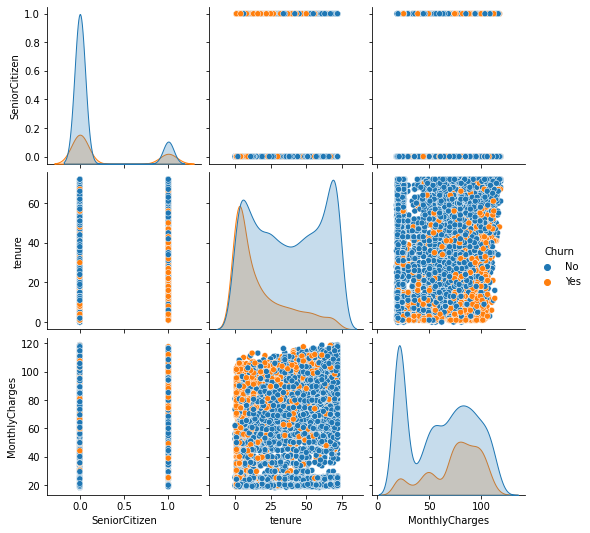

In [8]:
import seaborn as sns
pandasDF = df.toPandas()
sns.pairplot(pandasDF, hue="Churn")

In [9]:
df = df.withColumn("TotalCharges", 
                                  df["TotalCharges"]
                                  .cast('float'))

In [10]:
df. schema["TotalCharges"]

StructField(TotalCharges,FloatType,true)

In [11]:
from pyspark.sql.functions import col,isnan, when, count
df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]
   ).show()

+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|customerID|gender|SeniorCitizen|Partner|Dependents|tenure|PhoneService|MultipleLines|InternetService|OnlineSecurity|OnlineBackup|DeviceProtection|TechSupport|StreamingTV|StreamingMovies|Contract|PaperlessBilling|PaymentMethod|MonthlyCharges|TotalCharges|Churn|
+----------+------+-------------+-------+----------+------+------------+-------------+---------------+--------------+------------+----------------+-----------+-----------+---------------+--------+----------------+-------------+--------------+------------+-----+
|         0|     0|            0|      0|         0|     0|           0|            0|              0|             0|           0|               0|          0|          0|              0|       0|               0| 

In [12]:
print(df.na.drop().count())
print(df.count())

7032
7043


In [13]:
df=df.na.drop()

In [14]:
print(df.count())

7032


In [15]:
#Handling Categorical Feature using StringIndexer
from pyspark.ml.feature import StringIndexer
indexer = StringIndexer(inputCols=['gender','Partner','Dependents','PhoneService','MultipleLines',
                                   'InternetService','OnlineSecurity','OnlineBackup','DeviceProtection','TechSupport',
                                   'StreamingTV','StreamingMovies'\
                                  ,'Contract','PaperlessBilling','PaymentMethod','Churn'],\
                        outputCols=['gender-f','Partner-f','Dependents-f','PhoneService-f','MultipleLines-f',
                                    'InternetService-f','OnlineSecurity-f','OnlineBackup-f','DeviceProtection-f','TechSupport-f',
                                    'StreamingTV-f','StreamingMovies-f'\
                                    ,'Contract-f','PaperlessBilling-f','PaymentMethod-f','Churn-f'])
new=indexer.fit(df).transform(df)

In [16]:
from pyspark.ml.feature import VectorAssembler
assembler = VectorAssembler(inputCols=['gender-f',
                                       'SeniorCitizen',
                                       'Partner-f',
                                       'Dependents-f',
                                       'tenure',
                                       'PhoneService-f',
                                       'MultipleLines-f',
                                    'InternetService-f',
                                       'OnlineSecurity-f',
                                       'OnlineBackup-f',
                                       'DeviceProtection-f',
                                       'TechSupport-f',
                                    'StreamingTV-f',
                                       'StreamingMovies-f',
                                       'Contract-f',
                                       'PaperlessBilling-f',
                                       'PaymentMethod-f',
                                       'MonthlyCharges',
                                         'TotalCharges'],outputCol="features")

In [17]:
output = assembler.transform(new)

In [18]:
output.head(2)

[Row(customerID='7590-VHVEG', gender='Female', SeniorCitizen=0, Partner='Yes', Dependents='No', tenure=1, PhoneService='No', MultipleLines='No phone service', InternetService='DSL', OnlineSecurity='No', OnlineBackup='Yes', DeviceProtection='No', TechSupport='No', StreamingTV='No', StreamingMovies='No', Contract='Month-to-month', PaperlessBilling='Yes', PaymentMethod='Electronic check', MonthlyCharges=29.85, TotalCharges=29.850000381469727, Churn='No', gender-f=1.0, Partner-f=1.0, Dependents-f=0.0, PhoneService-f=1.0, MultipleLines-f=2.0, InternetService-f=1.0, OnlineSecurity-f=0.0, OnlineBackup-f=1.0, DeviceProtection-f=0.0, TechSupport-f=0.0, StreamingTV-f=0.0, StreamingMovies-f=0.0, Contract-f=0.0, PaperlessBilling-f=0.0, PaymentMethod-f=0.0, Churn-f=0.0, features=SparseVector(19, {0: 1.0, 2: 1.0, 4: 1.0, 5: 1.0, 6: 2.0, 7: 1.0, 9: 1.0, 17: 29.85, 18: 29.85})),
 Row(customerID='5575-GNVDE', gender='Male', SeniorCitizen=0, Partner='No', Dependents='No', tenure=34, PhoneService='Yes', 

In [19]:
finalDf = output.select("features","Churn-f")

In [20]:
finalDf.show()

+--------------------+-------+
|            features|Churn-f|
+--------------------+-------+
|(19,[0,2,4,5,6,7,...|    0.0|
|(19,[4,7,8,10,14,...|    0.0|
|(19,[4,7,8,9,16,1...|    1.0|
|[0.0,0.0,0.0,0.0,...|    0.0|
|(19,[0,4,17,18],[...|    1.0|
|(19,[0,4,6,10,12,...|    1.0|
|(19,[3,4,6,9,12,1...|    0.0|
|(19,[0,4,5,6,7,8,...|    0.0|
|(19,[0,2,4,6,10,1...|    1.0|
|(19,[3,4,7,8,9,14...|    0.0|
|(19,[2,3,4,7,8,16...|    0.0|
|[0.0,0.0,0.0,0.0,...|    0.0|
|(19,[2,4,6,10,12,...|    0.0|
|(19,[4,6,9,10,12,...|    1.0|
|(19,[4,8,10,11,12...|    0.0|
|[1.0,0.0,1.0,1.0,...|    0.0|
|[1.0,0.0,0.0,0.0,...|    0.0|
|[0.0,0.0,0.0,1.0,...|    0.0|
|(19,[0,2,3,4,7,10...|    1.0|
|(19,[0,4,9,10,13,...|    0.0|
+--------------------+-------+
only showing top 20 rows



In [33]:
trainData,testData = finalDf.randomSplit([0.70,0.30], seed=42)

In [34]:
from pyspark.ml.classification import LogisticRegression

In [35]:
lr = LogisticRegression(labelCol="Churn-f")

In [36]:
lrm = lr.fit(trainData)

In [37]:
lrm_summary = lrm.summary

In [38]:
lrm.summary.predictions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|Churn-f|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(19,[0,1,2,3,4,5,...|    0.0|[0.48883669589643...|[0.61983234936058...|       0.0|
|(19,[0,1,2,3,4,6,...|    0.0|[-0.5466237398650...|[0.36664808130848...|       1.0|
|(19,[0,1,2,3,4,6,...|    0.0|[-0.1020420486136...|[0.47451160067508...|       1.0|
|(19,[0,1,2,3,4,6,...|    0.0|[1.10023093503322...|[0.75030337336367...|       0.0|
|(19,[0,1,2,3,4,6,...|    0.0|[-0.3647583883383...|[0.40980818430609...|       1.0|
|(19,[0,1,2,3,4,6,...|    0.0|[-1.2973625157631...|[0.21460923586812...|       1.0|
|(19,[0,1,2,3,4,8,...|    1.0|[-0.1092313722959...|[0.47271927651293...|       1.0|
|(19,[0,1,2,3,4,9,...|    0.0|[0.15696176086282...|[0.53916007433188...|       0.0|
|(19,[0,1,2,3,4,10...|    1.0|[0.27413361282647...|[0.56810741808230...|    

In [39]:
lrm.summary.predictions.describe().show()

+-------+-------------------+-------------------+
|summary|            Churn-f|         prediction|
+-------+-------------------+-------------------+
|  count|               5028|               5028|
|   mean| 0.2684964200477327|0.22136038186157517|
| stddev|0.44322134730683505|0.41520386564597167|
|    min|                0.0|                0.0|
|    max|                1.0|                1.0|
+-------+-------------------+-------------------+



In [40]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [41]:
pred = lrm.evaluate(testData)

In [42]:
pred.predictions.show()

+--------------------+-------+--------------------+--------------------+----------+
|            features|Churn-f|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|(19,[0,1,2,3,4,6,...|    1.0|[0.31347615674492...|[0.57773352399677...|       0.0|
|(19,[0,1,2,3,4,6,...|    1.0|[0.06764110606331...|[0.51690383197161...|       0.0|
|(19,[0,1,2,3,4,6,...|    0.0|[-0.1053681159149...|[0.47368231572575...|       1.0|
|(19,[0,1,2,3,4,7,...|    1.0|[0.44397819328947...|[0.60920654525220...|       0.0|
|(19,[0,1,2,3,4,10...|    0.0|[-0.1779770638121...|[0.45562281262457...|       1.0|
|(19,[0,1,2,3,4,15...|    1.0|[1.62368793198370...|[0.83530311291702...|       0.0|
|(19,[0,1,2,3,4,17...|    1.0|[-1.0011439656840...|[0.26871656352493...|       1.0|
|(19,[0,1,2,4,6,7,...|    0.0|[2.70861123504604...|[0.93753286501498...|       0.0|
|(19,[0,1,2,4,6,8,...|    1.0|[-0.0659308948425...|[0.48352324440092...|    

In [43]:
evaluator = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Churn-f')

In [47]:
accuracy = evaluator.evaluate(pred.predictions)

In [48]:
print("FOR LogisticRegression")
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

FOR LogisticRegression
Accuracy = 0.7044569004106577
Test Error = 0.29554309958934233


In [49]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(featuresCol = 'features', labelCol = 'Churn-f')
rfModel = rf.fit(trainData)
predictions = rfModel.transform(testData)

In [51]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Churn-f", predictionCol="prediction")
accuracy = evaluator.evaluate(predictions)
print("FOR RandomForestClassifier")
print("Accuracy = %s" % (accuracy))
print("Test Error = %s" % (1.0 - accuracy))

FOR RandomForestClassifier
Accuracy = 0.7705054368353708
Test Error = 0.22949456316462924
